<a href="https://colab.research.google.com/github/chineidu/NLP-Tutorial/blob/main/notebook/Projects/Search/Hybrid-search/01-e-commerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# E-Commerce Hybrid Search

- Hybrid search is an information retrieval technique that combines multiple search algorithms to improve the accuracy and relevance of search results.
- It leverages the strengths of different approaches to overcome the limitations of each individually.

## Traditional Search Methods

- **Keyword-based search**: Relies on **matching keywords** in the query to keywords in documents. It's efficient but often misses semantically similar content.
- **Semantic search**: Uses **vector representations** (embeddings) to capture the **meaning of text**, allowing for retrieval based on semantic similarity. It can be less efficient for large datasets.

## Hybrid Search Approach

- It combines keyword and semantic search: Utilizes keywords for initial filtering and semantic similarity for deeper analysis.
- It provides results that are both semantically relevant and contain the query keywords.
- It offers a more intuitive and natural search experience.

## Implementation

- **Pinecone's** `sparse-dense` index allows us to perform seamless hybrid search for e-commerce or in any other context.

In [3]:
!pip install -qU transformers[torch] datasets evaluate \
                sentence-transformers pinecone-client pinecone-text \
                protobuf python-dotenv

In [4]:
# Built-in library
import re
import json
from typing import Any, Optional, Union
import logging
import warnings

# Standard importsa
import numpy as np
from pathlib import Path
import pandas as pd
import polars as pl
from pprint import pprint
from rich import print
import torch

# Visualization
import matplotlib.pyplot as plt


# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

warnings.filterwarnings("ignore")

# # Black code formatter (Optional)
# %load_ext lab_black

# # auto reload imports
# %load_ext autoreload
# %autoreload 2

In [ ]:
import os

from dotenv import load_dotenv, find_dotenv


load_dotenv(dotenv_path=find_dotenv(filename=".env"))


def load_creds() -> tuple[Optional[str], Optional[str], Optional[str], Optional[str]]:
    """This is used to load the credentials."""
    OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
    PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")
    PINECONE_ENV = os.getenv("PINECONE_ENV")
    QDRANT_API_KEY = os.getenv("QDRANT_API_KEY")

    return (OPENAI_API_KEY, PINECONE_API_KEY, PINECONE_ENV, QDRANT_API_KEY)


(OPENAI_API_KEY, PINECONE_API_KEY, PINECONE_ENV, QDRANT_API_KEY) = load_creds()

In [5]:
from getpass import getpass


RUN_CELL: bool = True

if RUN_CELL:
    # Get API key without displaying it
    PINECONE_API_KEY: str = getpass("Please enter your API key: ")
    PINECONE_ENV: str = "us-west4-gcp-free"

Please enter your API key: ··········


## Initialize Connection To Pinecone

In [6]:
import pinecone


pinecone.init(api_key=PINECONE_API_KEY, environment=PINECONE_ENV)

### Note

- To use the `sparse-dense` index in `Pinecone`, we must set the `metri="dotproduct"` and use either `s1` or `p1` pods.

In [7]:
INDEX_NAME: str = "hybrid-image-search"
VECTOR_DIMENSION: int = 512
METRIC: str = "dotproduct"
POD_TYPE: str = "s1"

# Create index
if INDEX_NAME not in pinecone.list_indexes():
    pinecone.create_index(
        name=INDEX_NAME,
        dimension=VECTOR_DIMENSION,
        metric=METRIC,
        pod_type=POD_TYPE,
    )

# Connect to the Pinecone index
index = pinecone.Index(index_name=INDEX_NAME)

## Load Data

- We'll be using a subset of the Open Fashion Product Images dataset which contains ~44k fashion products with images.
- The data can be found on [kaggle](https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small).
- It can also be found here on [HuggingFace](https://huggingface.co/datasets/ashraq/fashion-product-images-small).

In [8]:
from datasets import Dataset, DatasetDict, load_dataset


PATH: str = "ashraq/fashion-product-images-small"
SPLIT: str = "train"

fashion_data: Dataset = load_dataset(path=PATH, split=SPLIT)

fashion_data

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/44072 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image'],
    num_rows: 44072
})

In [9]:
# Extract the images and create the metadata/payload
images: list[Any] = fashion_data["image"]
metadata: Dataset = fashion_data.remove_columns(column_names=["image"])

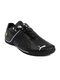

In [10]:
# Display a product
images[10]

In [11]:
# Convert metadata to a DataFrame
metadata = metadata.to_pandas()
metadata.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [12]:
# Concatenate the data to create product description
# Sample
A = metadata.iloc[:3]

COLUMNS: list[str] = [
    "gender",
    "masterCategory",
    "subCategory",
    "articleType",
    "baseColour",
    "season",
    "usage",
    "productDisplayName",
]
A[COLUMNS].agg(" ".join, axis=1)

0     Men Apparel Topwear Shirts Navy Blue Fall Casual Turtle Check Men Navy Blue Shirt
1    Men Apparel Bottomwear Jeans Blue Summer Casual Peter England Men Party Blue Jeans
2       Women Accessories Watches Watches Silver Winter Casual Titan Women Silver Watch
dtype: object

In [13]:
metadata = metadata.assign(productDetails=lambda df: df[COLUMNS].agg(" ".join, axis=1))

metadata.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,productDetails
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,Men Apparel Topwear Shirts Navy Blue Fall Casual Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,Men Apparel Bottomwear Jeans Blue Summer Casual Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,Women Accessories Watches Watches Silver Winter Casual Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,Men Apparel Bottomwear Track Pants Black Fall Casual Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,Men Apparel Topwear Tshirts Grey Summer Casual Puma Men Grey T-shirt


<br>

## Sparse Vectors

- Sparse vectors are vectors with too many zero values.

### BM25

- `BM25` (Best Matching 25) is a `ranking function` used in information retrieval systems, particularly search engines, to estimate the relevance of documents to a given search query.
- It is a `bag-of-words` model, meaning it considers the `occurrence of individual terms` in documents without regard to their order or proximity.

- Create a `sparse` using the `BM25` algorithm which has been implemented by `Pinecone-text`

```sh
pip install "pinecone-text[splade]"
```

In [14]:
from pinecone_text.sparse import BM25Encoder


bm25: BM25Encoder = BM25Encoder()
bm25

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
# Train the encoder
bm25.fit(corpus=metadata["productDetails"])

  0%|          | 0/44072 [00:00<?, ?it/s]

In [16]:
query: str = metadata["productDetails"].iloc[0]
query

'Men Apparel Topwear Shirts Navy Blue Fall Casual Turtle Check Men Navy Blue Shirt'

In [17]:
bm25.encode_queries(texts=query)

{'indices': [632192512,
  1540502846,
  2795873812,
  3828986392,
  931643408,
  3905155331,
  453950983,
  4127429595,
  23789636,
  1830646559],
 'values': [0.033226775453346284,
  0.03490510161148579,
  0.05072705308188816,
  0.12594198072251941,
  0.15018442794166703,
  0.08668186009595047,
  0.06510033533293173,
  0.011811300452238375,
  0.2773844203738264,
  0.16403674493414633]}

In [18]:
# Calculate the IDF which is what will be stored in the Pinecone VectorDB
bm25.encode_documents(texts=query)

{'indices': [632192512,
  1540502846,
  2795873812,
  3828986392,
  931643408,
  3905155331,
  453950983,
  4127429595,
  23789636,
  1830646559],
 'values': [0.6127809658942706,
  0.44173338948546054,
  0.44173338948546054,
  0.6127809658942706,
  0.6127809658942706,
  0.6127809658942706,
  0.44173338948546054,
  0.44173338948546054,
  0.44173338948546054,
  0.44173338948546054]}

In [ ]:
# Load Clip model from HuggingFace
from sentence_transformers import SentenceTransformer


device: str = "cuda" if torch.cuda.is_available else "cpu"
MODEL_CHECKPOINT: str = "clip-ViT-B-16"

# Load CLIP model
model: SentenceTransformer = SentenceTransformer(MODEL_CHECKPOINT)
model

.gitattributes:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

0_CLIPModel/config.json:   0%|          | 0.00/4.31k [00:00<?, ?B/s]

0_CLIPModel/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

0_CLIPModel/preprocessor_config.json:   0%|          | 0.00/354 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

In [ ]:
# Shape of embeddings
model.encode(sentences=query)